In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import random
random.seed(100)
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('Breast_Cancer.csv')
df.head()
df.shape[0]


4024

In [3]:
df.rename(columns={'T Stage ': 'T Stage'}, inplace=True)
df.isnull().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

In [4]:
df["Grade"].value_counts()

2                        2351
3                        1111
1                         543
 anaplastic; Grade IV      19
Name: Grade, dtype: int64

In [5]:
df["Grade"] = df["Grade"].apply(lambda x: int(x.replace(" anaplastic; Grade IV", "4")))

## Data exploration and visualization

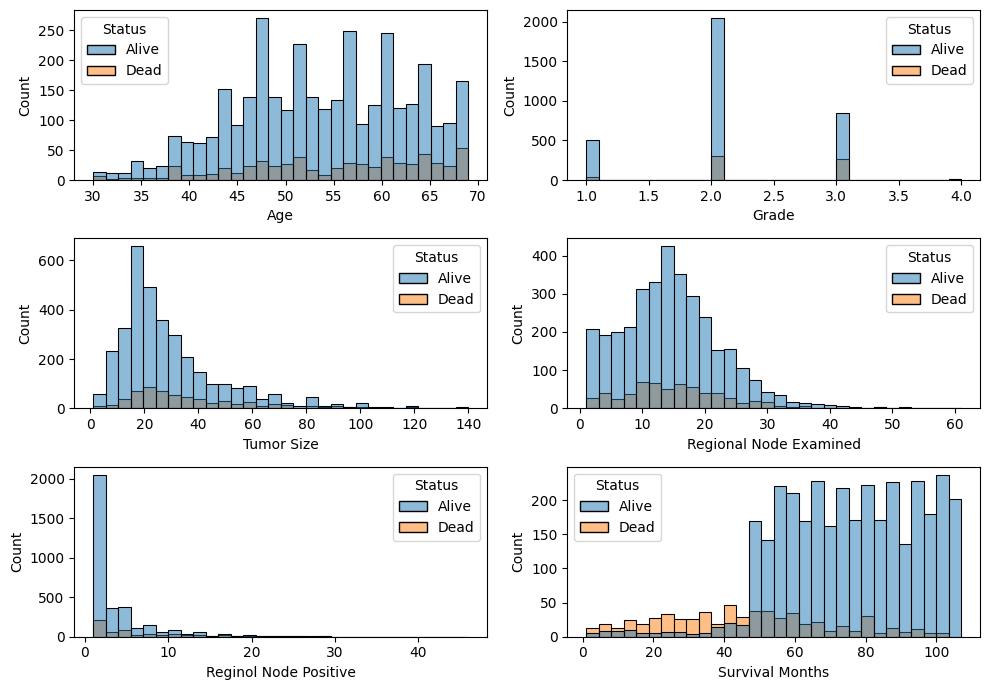

In [6]:
import math

num_columns = df.select_dtypes(include=['float64', 'int64']).columns
n = len(num_columns)
ncols = 2  
nrows = math.ceil(n / ncols)  
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7))
if nrows == 1:
    axs = axs.reshape(1, -1)

# Plot data
for idx, column in enumerate(num_columns):
    row = idx // ncols
    col = idx % ncols
    sns.histplot(x=column, hue='Status', data=df, bins=30, ax=axs[row, col])
if n % ncols != 0:
    for idx in range(n, nrows*ncols):
        fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

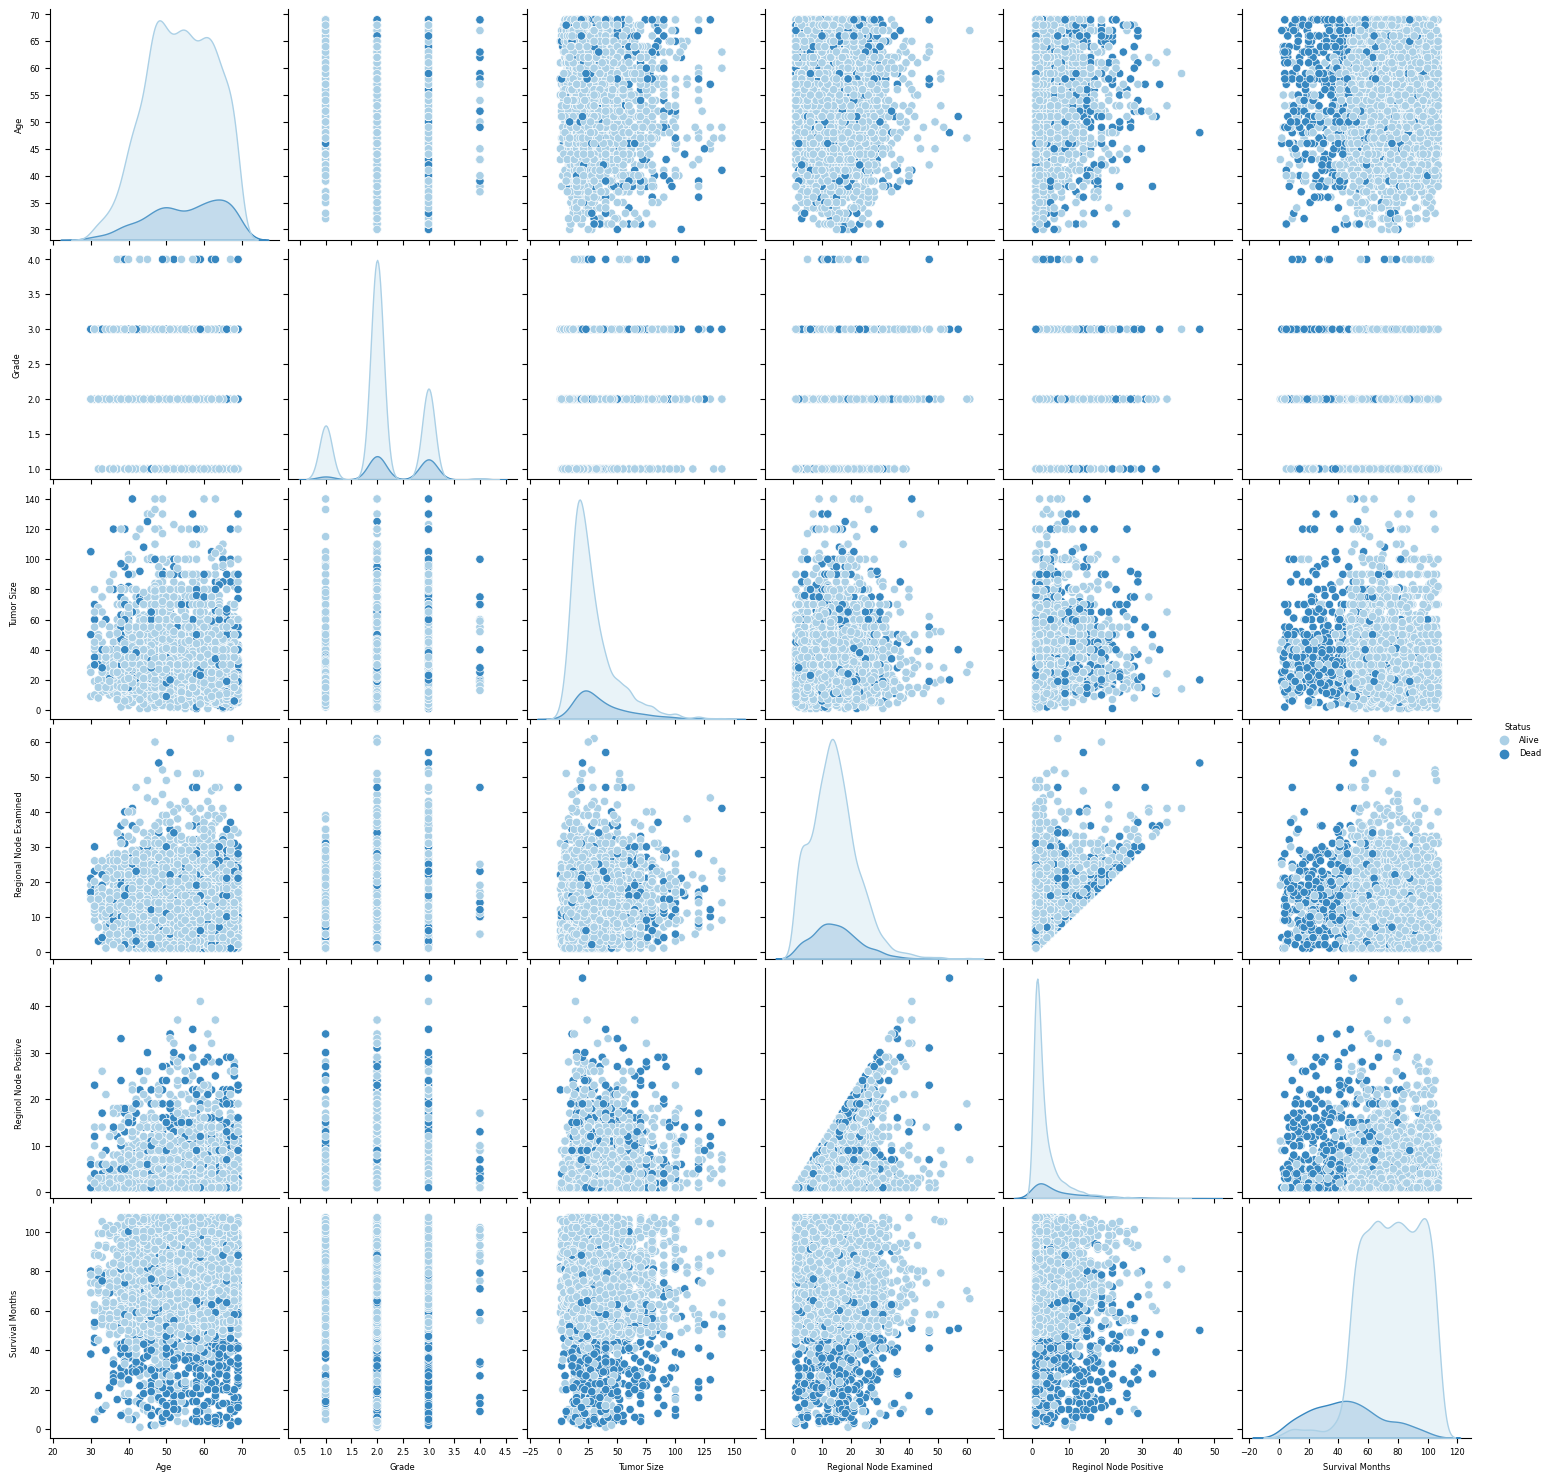

In [7]:
plt.rcParams['font.size']= 6
sns.pairplot(df,hue='Status', palette='Blues')

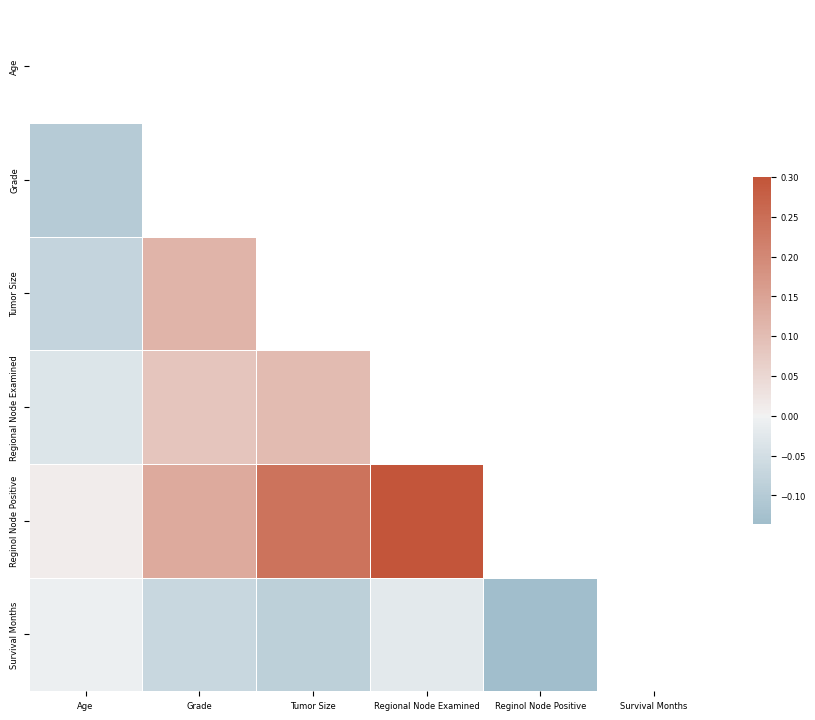

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

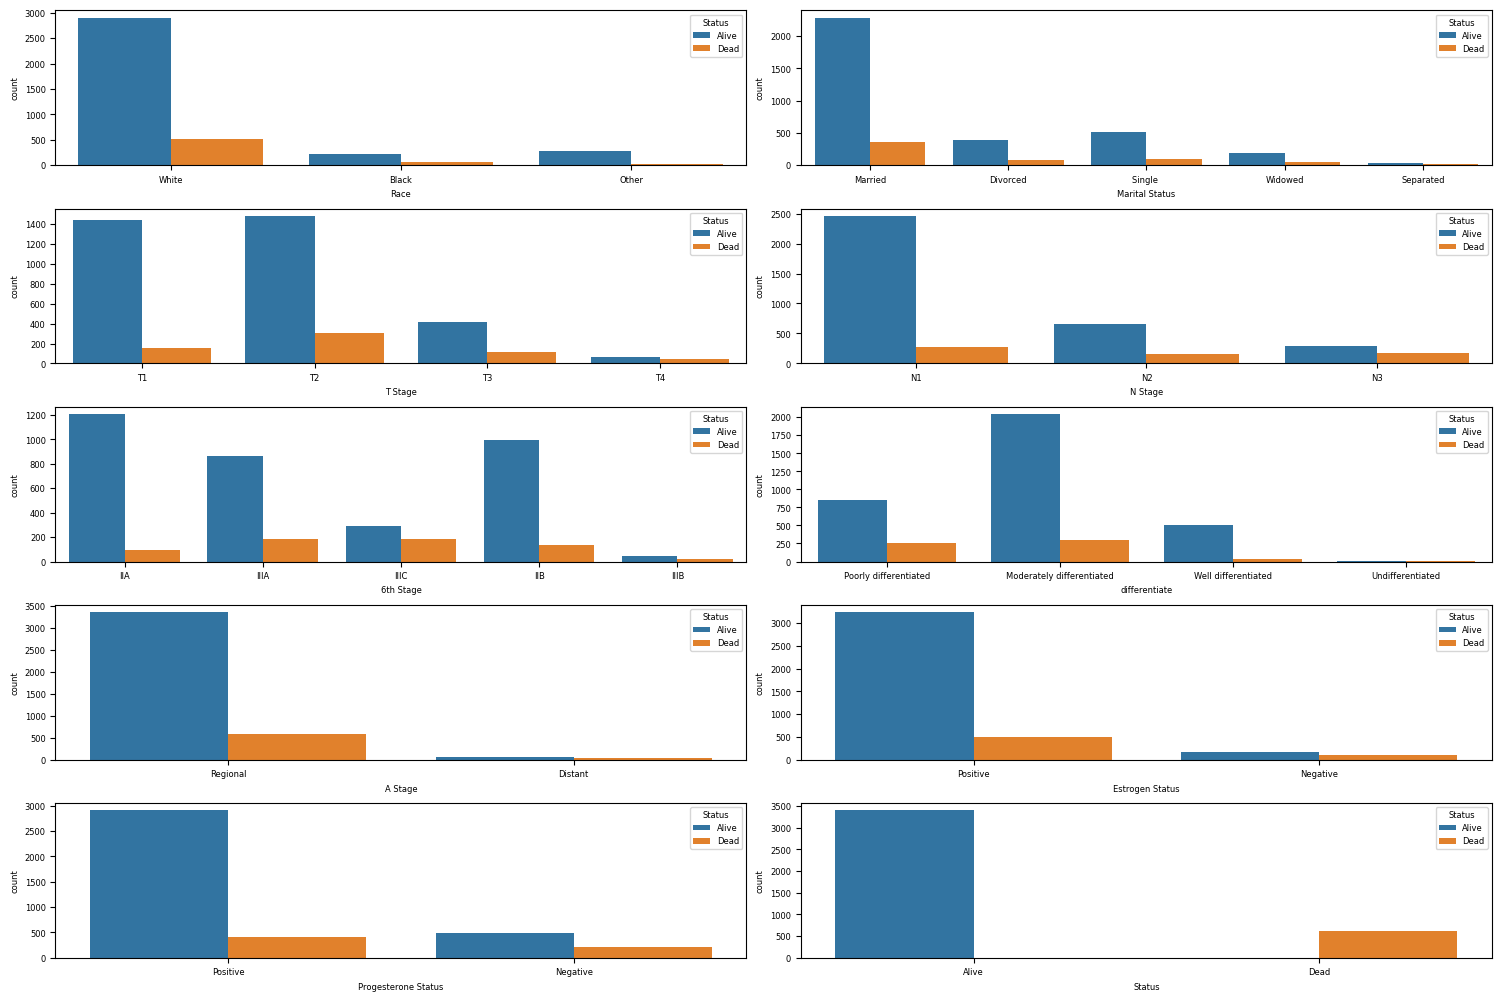

In [9]:
import math

cat_columns = df.select_dtypes(include=['object']).columns
n = len(cat_columns)
ncols = 2  
nrows = math.ceil(n / ncols)  
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
if nrows == 1:
    axs = axs.reshape(1, -1)

# Plot data
for idx, column in enumerate(cat_columns):
    row = idx // ncols
    col = idx % ncols
    sns.countplot(x=column, hue='Status', data=df, ax=axs[row, col])

if n % ncols != 0:
    for idx in range(n, nrows*ncols):
        fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()


### Outliers

In [10]:
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return df[(df[column] < lower_limit) | (df[column] > upper_limit)]

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

numerical_cols = df.select_dtypes(include=[np.number]).columns
for column in numerical_cols:
    outliers = identify_outliers(df, column)
    print(f"\nOutliers for {column}:")
    print(outliers[column])
    print(f"Number of outliers in {column}: {len(outliers)}")

for column in numerical_cols:
    df = remove_outliers(df, column)


num_rows_before = df.shape[0]
df_encoded = df.dropna()
num_rows_after = df.shape[0]

print(f"Number of rows before dropping NA: {num_rows_before}")
print(f"Number of rows after dropping NA: {num_rows_after}")
print(f"Number of rows dropped: {num_rows_before - num_rows_after}")


Outliers for Age:
Series([], Name: Age, dtype: int64)
Number of outliers in Age: 0

Outliers for Grade:
Series([], Name: Grade, dtype: int64)
Number of outliers in Grade: 0

Outliers for Tumor Size:
289     140
740     140
894     133
1007    140
1512    140
3965    140
Name: Tumor Size, dtype: int64
Number of outliers in Tumor Size: 6

Outliers for Regional Node Examined:
941     61
2462    57
3950    60
Name: Regional Node Examined, dtype: int64
Number of outliers in Regional Node Examined: 3

Outliers for Reginol Node Positive:
100     24
219     27
238     26
288     28
482     24
522     28
530     28
535     24
544     29
550     31
574     26
633     46
662     27
838     33
909     29
922     27
989     37
1039    28
1116    24
1120    30
1128    37
1199    27
1246    26
1267    35
1382    25
1411    24
1567    29
1667    29
1711    25
1872    26
2028    29
2031    27
2142    32
2182    41
2287    26
2293    28
2425    28
2568    26
2638    28
2755    26
2928    30
2934    34


In [11]:
categorical_cols = ['Race', 'Marital Status', 'A Stage', 'T Stage', 'N Stage',
                     '6th Stage', 'differentiate', 'Estrogen Status', 'Progesterone Status']

onehot_encoder = OneHotEncoder(sparse=False)
encoded_cols = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_cols]))
encoded_cols.columns = onehot_encoder.get_feature_names_out()
numerical_cols = df[['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months', 'Grade']]
df_encoded = pd.concat([numerical_cols.reset_index(drop=True), encoded_cols.reset_index(drop=True), df["Status"].reset_index(drop=True)], axis=1)

scaler = StandardScaler()
df_encoded[['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months', 'Grade']] = scaler.fit_transform(
    df_encoded[['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months', 'Grade']])


num_rows_before = df_encoded.shape[0]
df_encoded = df_encoded.dropna()
num_rows_after = df_encoded.shape[0]

print(df_encoded.head())

print(f"Number of rows before dropping NA: {num_rows_before}")
print(f"Number of rows after dropping NA: {num_rows_after}")
print(f"Number of rows dropped: {num_rows_before - num_rows_after}")


        Age  Tumor Size  Regional Node Examined  Reginol Node Positive  \
0  1.563856   -1.270061                1.279041              -0.665684   
1 -0.441500    0.233178               -0.009696               0.280583   
2  0.449769    1.590942               -0.009696               0.753717   
3  0.449769   -0.591179               -1.556179              -0.665684   
4 -0.775726    0.524128               -1.427306              -0.665684   

   Survival Months     Grade  Race_Black  Race_Other  Race_White  \
0        -0.504040  1.331407         0.0         0.0         1.0   
1        -0.416382 -0.235350         0.0         0.0         1.0   
2         0.153396 -0.235350         0.0         0.0         1.0   
3         0.547858  1.331407         0.0         0.0         1.0   
4        -0.942331  1.331407         0.0         0.0         1.0   

   Marital Status_Divorced  ...  6th Stage_IIIC  \
0                      0.0  ...             0.0   
1                      0.0  ...             

## K Means Clustering

The optimal number of clusters according to Elbow Method is: 11
The optimal number of clusters according to Silhouette Score is: 2


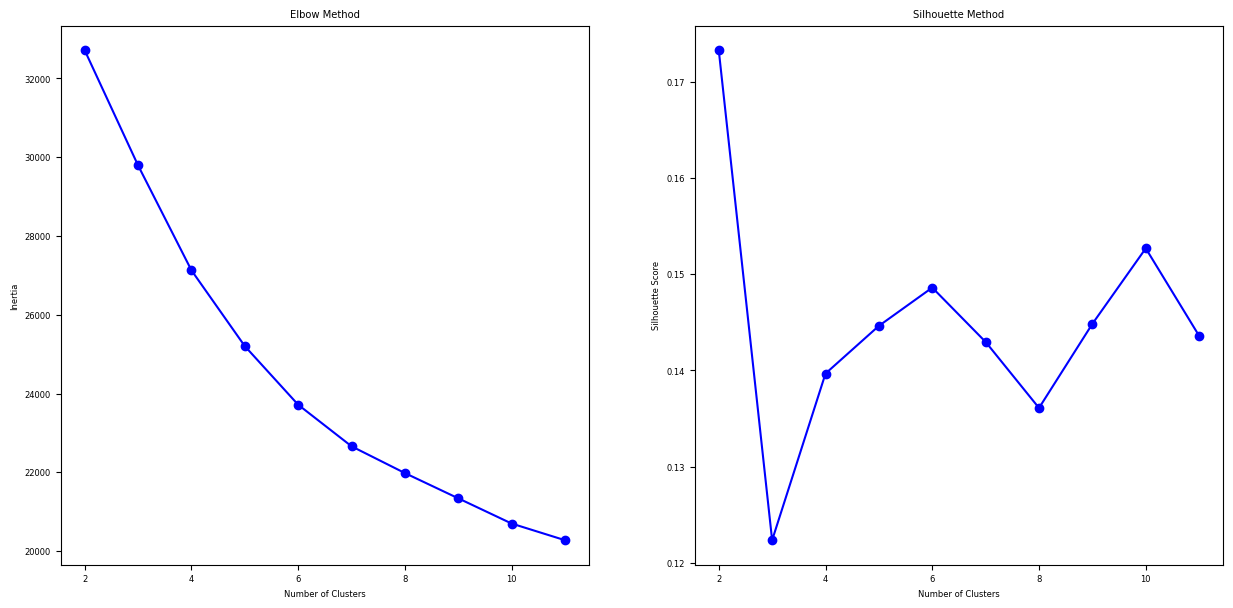

In [12]:
df_encoded_cluster = df_encoded.drop(['Status'], axis=1)

elbow_scores = []
silhouette_scores = []

cluster_range = range(2, 12)

for num_clusters in cluster_range:
    # Elbow Method
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_encoded_cluster)
    elbow_scores.append(kmeans.inertia_)
    
    # Silhouette Method
    if num_clusters > 1:  
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(df_encoded_cluster, cluster_labels)
        silhouette_scores.append(silhouette_avg)

optimal_clusters_elbow = elbow_scores.index(min(elbow_scores)) + 2
optimal_clusters_silhouette = silhouette_scores.index(max(silhouette_scores)) + 2

print(f"The optimal number of clusters according to Elbow Method is: {optimal_clusters_elbow}")
print(f"The optimal number of clusters according to Silhouette Score is: {optimal_clusters_silhouette}")

# Plots for Elbow and Silhouette Methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

ax1.plot(cluster_range, elbow_scores, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

ax2.plot(cluster_range, silhouette_scores, 'bo-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Method')

plt.show()

In [13]:
import scipy.stats as stats
import seaborn as sns

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_encoded_cluster)
df_clusters = pd.DataFrame({'Cluster': clusters, 'Status': df_encoded['Status']})
cluster_status_counts = pd.crosstab(df_clusters['Cluster'], df_encoded['Status'])

# Calculate the percentage distribution of 'Status' within each cluster
cluster_status_percentages = cluster_status_counts.div(cluster_status_counts.sum(axis=1), axis=0) * 100
print("Distribution of Status within each Cluster:")
print(cluster_status_counts)
print("\nPercentage Distribution of Status within each Cluster:")
print(cluster_status_percentages)


# Conduct a chi-square test of independence
chi2, p, _, _ = stats.chi2_contingency(pd.crosstab(df_clusters['Cluster'], df_encoded['Status']))
print("Chi-square Test of Independence:")
print("Chi-square statistic:", chi2)
print("p-value:", p)



Distribution of Status within each Cluster:
Status   Alive  Dead
Cluster             
0         1033   344
1         2341   243

Percentage Distribution of Status within each Cluster:
Status       Alive       Dead
Cluster                      
0        75.018155  24.981845
1        90.595975   9.404025
Chi-square Test of Independence:
Chi-square statistic: 171.45587729556325
p-value: 3.557919397985091e-39


## KNN model

In [441]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# remove Survival Months
X = df_encoded.drop(['Status', 'Survival Months'], axis=1)
y = df_encoded['Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123)


knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
knn_cv.best_params_
knn_cv.best_score_

# test set accuracy
knn_cv.score(X_test, y_test)

0.8811320754716981

In [442]:
y_pred = knn_cv.predict(X_test)
print(classification_report(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

       Alive       0.88      1.00      0.94       468
        Dead       0.00      0.00      0.00        62

    accuracy                           0.88       530
   macro avg       0.44      0.50      0.47       530
weighted avg       0.78      0.88      0.83       530



In [443]:
confusion_matrix(y_test.to_numpy(), y_pred)

array([[467,   1],
       [ 62,   0]], dtype=int64)

In [444]:
r = permutation_importance(knn_cv, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

## SVM with custom kernel

In [445]:
from numba import njit
import numba as nb
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# gammaList = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
CList = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

@njit
def histogramKernel(xs, ys):
    return np.minimum(xs, ys).sum()

class GramBuilder:
    def __init__(self, Kernel):
        self._Kernel = Kernel
    def generateMatrixBuilder(self, X1, X2):
        gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
        for i, x1 in enumerate(X1):
            for j, x2 in enumerate(X2):
                gram_matrix[i, j] = self._Kernel(x1, x2)
        
        return gram_matrix
    

histo_svc = svm.SVC(kernel=GramBuilder(histogramKernel).generateMatrixBuilder)
histo_clf = GridSearchCV(histo_svc, {'C' : CList}, verbose = 1, n_jobs = -1)
histo_clf.fit(X_train.to_numpy(), y_train.to_numpy())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(estimator=SVC(kernel=<bound method GramBuilder.generateMatrixBuilder of <__main__.GramBuilder object at 0x0000028739C27370>>),
             n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             verbose=1)

In [446]:
print("Best parameters set found on development set:")
print(histo_clf.best_params_)
print() 
print("Grid scores on train set:")
means = histo_clf.cv_results_['mean_test_score']
stds = histo_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, histo_clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std * 2, params))

Best parameters set found on development set:
{'C': 0.001}

Grid scores on train set:
0.888 (+/-0.002) for {'C': 0.001}
0.888 (+/-0.002) for {'C': 0.01}
0.888 (+/-0.002) for {'C': 0.1}
0.887 (+/-0.005) for {'C': 1}
0.886 (+/-0.006) for {'C': 10}
0.886 (+/-0.006) for {'C': 100}
0.886 (+/-0.006) for {'C': 1000}


In [447]:
# test set

y_pred = histo_clf.predict(X_test.to_numpy())
print("Accuracy score on test set: ", accuracy_score(y_test.to_numpy(), y_pred))

Accuracy score on test set:  0.8830188679245283


In [448]:
confusion_matrix(y_test.to_numpy(), y_pred)

array([[468,   0],
       [ 62,   0]], dtype=int64)

In [449]:
print(classification_report(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

       Alive       0.88      1.00      0.94       468
        Dead       0.00      0.00      0.00        62

    accuracy                           0.88       530
   macro avg       0.44      0.50      0.47       530
weighted avg       0.78      0.88      0.83       530



## Random forest based classifiers

In [450]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
param_grid = {'n_estimators': np.arange(1, 100, 10), 'max_depth': np.arange(3, 25, 3),
               'min_samples_split': np.arange(2, 5)}
rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X_train, y_train)
rf_cv.best_params_, rf_cv.best_score_

({'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 81},
 0.8894152281546901)

In [451]:
y_pred = rf_cv.predict(X_test)

print(classification_report(y_test.to_numpy(), y_pred))

confusion_matrix(y_test.to_numpy(), y_pred)


              precision    recall  f1-score   support

       Alive       0.88      1.00      0.94       468
        Dead       0.50      0.02      0.03        62

    accuracy                           0.88       530
   macro avg       0.69      0.51      0.48       530
weighted avg       0.84      0.88      0.83       530



array([[467,   1],
       [ 61,   1]], dtype=int64)